# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [1]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


## folder variables

In [2]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/socket/600/600"
wantedCSVfilename = "data-batch-vs-acc-1200-1200.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [4]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [5]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename)
    return select_columns_and_rename_values(df)

In [12]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    print(df)
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [7]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
#     return df[df['algorithm'].str.contains(string, regex=False)]
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [8]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']
    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [9]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
#     datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    datasets = ['elecNormNew']

    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [13]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
                                            dataset  algorithm  ensemble_size  \
covtypeNorm  StreamingRandomPatchesExecutorMAXChunk         25              4   
elecNormNew                    LBagExecutorMAXChunk         25              4   
elecNormNew  StreamingRandomPatchesExecutorMAXChunk         25              4   
elecNormNew              OzaBagASHTExecutorMAXChunk         25              4   
elecNormNew                    LBagExecutorMAXChunk         25              4   
elecNormNew  StreamingRandomPatchesExecutorMAXChunk         25              4   
elecNormNew  StreamingRandomPatchesExecutorMAXChunk         25              4   
covtypeNorm    AdaptiveRandomForestExecutorMAXChunk         25              4   
elecNormNew    AdaptiveRandomForestExecutorMAXChunk         25              4   
elecNormNew    AdaptiveRandomForestExecutorMAXChunk         25              4   
elecNormNew  StreamingRandomPatches

AttributeError: Can only use .str accessor with string values!

**show charts**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


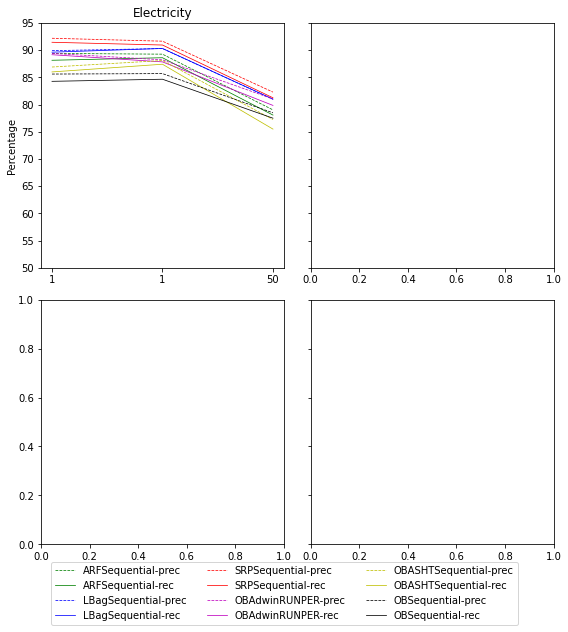

In [69]:
#false makes the chart without markers
gen_chart(df,False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


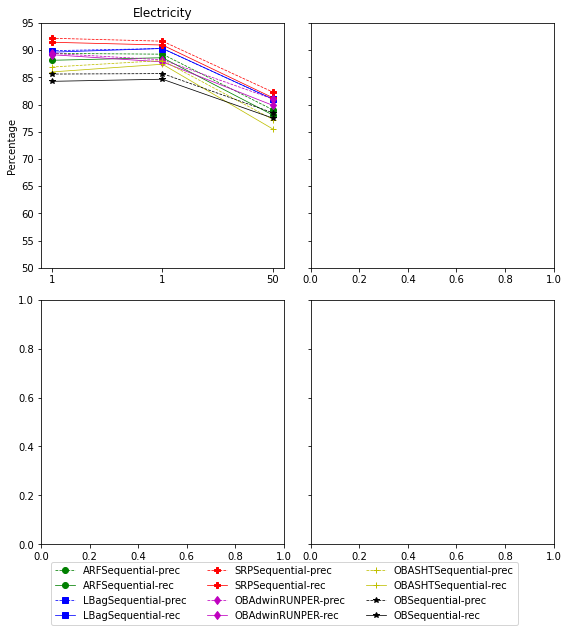

In [70]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
47,elecNormNew,ARFSequential,100,1,4189.0,89.329196,89.40818080197761,88.14892966885661,0.0
6,elecNormNew,ARFRUNPER,100,1,7845.0,89.330784,89.27068115758361,88.61676227643358,0.0
58,elecNormNew,ARFMB,150,50,7300.0,79.613793,79.0287650945499,78.07490359267086,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
40,elecNormNew,LBagSequential,100,1,6652.0,90.228503,89.91306445768227,89.63701870583947,67.0
14,elecNormNew,LBagRUNPER,100,1,13165.0,90.436764,90.30155966304498,90.32268120634885,115.0
64,elecNormNew,LBagMB,150,50,13000.0,81.235521,80.98570656307223,81.00103281746752,255.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
1,elecNormNew,SRPSequential,100,1,2746.0,92.134013,92.1943634161826,91.45677082732237,0.0
70,elecNormNew,SRPRUNPER,100,1,5294.0,91.764261,91.6571910743277,90.95085739314086,0.0
16,elecNormNew,SRPMB,150,50,5100.0,82.831683,82.29484673913507,81.25123607357109,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
62,elecNormNew,OBAdwinRUNPER,100,1,19706.0,89.485436,89.4124655262956,89.16892624423627,0.0
8,elecNormNew,OBAdwinSequential,100,1,18968.0,88.285534,88.23445348157367,87.85154816307906,199.0
10,elecNormNew,OBAdwinMB,150,50,31500.0,81.074722,81.03911316027333,79.85115003271429,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
45,elecNormNew,OBASHTSequential,100,1,19874.0,86.691154,86.90764484530916,86.00521230003697,0.0
4,elecNormNew,OBASHTRUNPER,100,1,18335.0,87.979275,88.10184595289493,87.42058071954358,0.0
51,elecNormNew,OBASHTMB,150,50,32200.0,77.200622,77.26048195081552,75.49830680270787,0.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
34,elecNormNew,OBSequential,100,1,26661.0,85.315630,85.61454775332001,84.27797507969449,0.0
38,elecNormNew,OBRUNPER,100,1,27087.0,85.550264,85.69948502967468,84.66424367262081,0.0
68,elecNormNew,OBMB,150,50,36650.0,78.792350,78.48821915438423,77.50223369838574,0.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


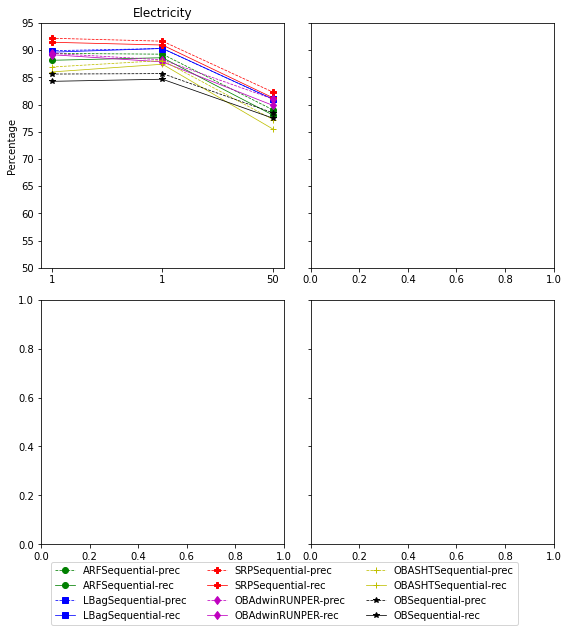

In [71]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)